# Plotting neurite length

In [2]:
import numpy as np
import pandas as pd
import random
from scipy import stats

from matplotlib import rcParams as rc
from matplotlib import pyplot as plt

from lib import plot, u

In [3]:
rc.update({'font.size': 20})

## Reading data

In [4]:
pyrs_raw = pd.read_csv('data/pyr_neurite_lengths.csv', index_col=0)
inhs = pd.read_csv('data/inh_neurite_lengths.csv', index_col=0)

In [5]:
pyrs_clean_compartments = u.read_ids("data/clean_compartment_ids_v185.csv")

In [6]:
pyrs = pyrs_raw[pyrs_raw.pt_root_id.isin(pyrs_clean_compartments)]

In [7]:
pyrs.head(1)

,cell_type,pt_position,pt_root_id,axon_lengths_um,apical_dend_lengths_um,basal_dend_lengths_um,ambiguous_dend_lengths_um
1,e,[84054 50604 1424],648518346349538466,[59.05064129049888],"[146.08713414259014, 135.36520528654188, 85.83...","[146.08713414259014, 135.36520528654188, 85.83...","[44.28541110779654, 97.37027331260785, 64.9004..."


## Formatting data

In [8]:
def length_frame(df, lengthcol, celltype, neuritetype):
    cellids, lengths, celltypes, neuritetypes = [], [], [], []
    
    for (cellid, lens) in zip(df["pt_root_id"], df[lengthcol]):
        for length in eval(lens):
            cellids.append(cellid)
            lengths.append(length)
            celltypes.append(celltype)
            neuritetypes.append(neuritetype)
    
    data_dict = {
        "cellid": cellids,
        "neuritelength": lengths,
        "celltype": celltypes,
        "neuritetype": neuritetypes
    }

    return pd.DataFrame(data_dict)


def assemble_pyr_data(df):
    axondf = length_frame(df, "axon_lengths_um", "pyramidal", "axon")
    basaldf = length_frame(df, "basal_dend_lengths_um", "pyramidal", "basal")
    apicaldf = length_frame(df, "apical_dend_lengths_um", "pyramidal", "apical")
    
    return pd.concat((axondf, basaldf, apicaldf), ignore_index=True)


def assemble_inh_data(df):
    typedfs = []
    for (typename, subdf) in df.groupby("forrest_tag"):
        typedfs.append(assemble_typedf(subdf, typename))
    
    return pd.concat(typedfs, ignore_index=True)


def assemble_typedf(df, celltype):
    neuritedfs = []
    axondf = length_frame(df, "axon_lengths_um", celltype, "axon")
    denddf = length_frame(df, "dendrite_lengths_um", celltype, "dendrite")
    
    return pd.concat((axondf, denddf), ignore_index=True)


def assemble_all_data():
    pyrdf = assemble_pyr_data(pyrs)
    inhdf = assemble_inh_data(inhs)
    
    return pd.concat((pyrdf, inhdf), ignore_index=True)

In [9]:
data = assemble_all_data()

In [10]:
data.loc[data.celltype == "unknown_type", "celltype"] = "unclassified"

In [11]:
plotdf = data.groupby(["cellid", "celltype", "neuritetype"])["neuritelength"].\
    quantile([0.05, 0.5, 0.95]).unstack().reset_index()

In [12]:
plotdf.head()

,cellid,celltype,neuritetype,0.05,0.5,0.95
0,648518346349477331,bipolar,axon,66.320367,182.381953,321.115928
1,648518346349477331,bipolar,dendrite,14.907629,41.191849,115.981463
2,648518346349487432,bipolar,dendrite,5.608375,50.099377,106.246134
3,648518346349487752,bipolar,axon,41.109148,41.109148,41.109148
4,648518346349487752,bipolar,dendrite,14.267682,59.603715,134.409277


In [13]:
plotdf["celltype"] = [c.capitalize() for c in plotdf.celltype]

## Plotting

In [14]:
def _errorbar_w_jitter(xs, ys, errslow, errshi,
                      jitter=0.2, seed=None, **kwargs):
    if seed is not None:
        np.random.seed(seed)

    xs = xs + stats.uniform(-jitter, 2*jitter).rvs(len(xs))
    low = ys - errslow
    hi = errshi - ys
    
    plt.errorbar(xs, ys, yerr=[low, hi],
                 marker='', linestyle='', color="tab:gray")
    plt.scatter(xs, ys, marker='o', s=20, color='k', zorder=10)
    

def errorbar_w_jitter(df, levels, levelcolname="celltype",
                      seed=None, level_xs=None):
    df = df[df[levelcolname].isin(levels)]
    
    if level_xs is None:
        level_xs = list(range(len(levels)))

    levelmap = {level: x for (level, x) in zip(levels, level_xs)}
    xs = [levelmap[v] for v in df[levelcolname]]
    
    _errorbar_w_jitter(xs, df[0.5], df[0.05], df[0.95], seed=seed)
    
    plt.xticks(level_xs, levels, rotation=45)

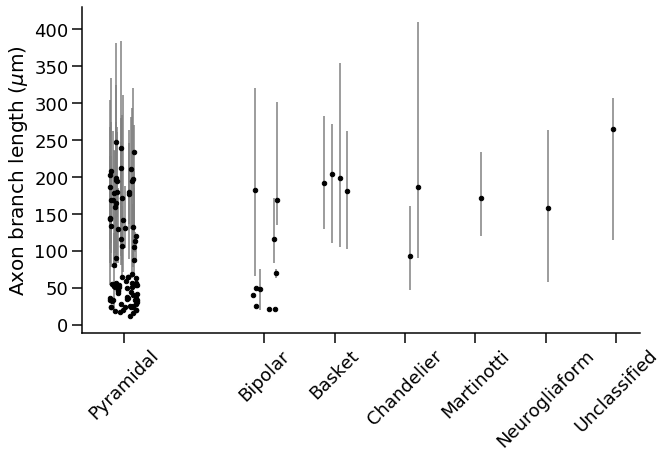

In [15]:
plt.figure(figsize=(10, 6))
levels = ["Pyramidal", "Bipolar", "Basket",
          "Chandelier", "Martinotti",
          "Neurogliaform", "Unclassified"]

errorbar_w_jitter(plotdf[plotdf.neuritetype == "axon"], levels,
                  level_xs = [0, 2, 3, 4, 5, 6, 7], seed=67234697)
plt.ylabel("Axon branch length ($\mu$m)")

plot.format_axes()
plt.show()

In [16]:
denddf = plotdf[plotdf.neuritetype != "axon"]

full_neuritetype = []
for (celltype, neuritetype) in zip(denddf.celltype, denddf.neuritetype):
    if celltype != "Pyramidal":
        full_neuritetype.append(celltype)
    else:
        full_neuritetype.append(f"{celltype}\n{neuritetype}")

denddf["full_celltype"] = full_neuritetype

/usr/people/nturner/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


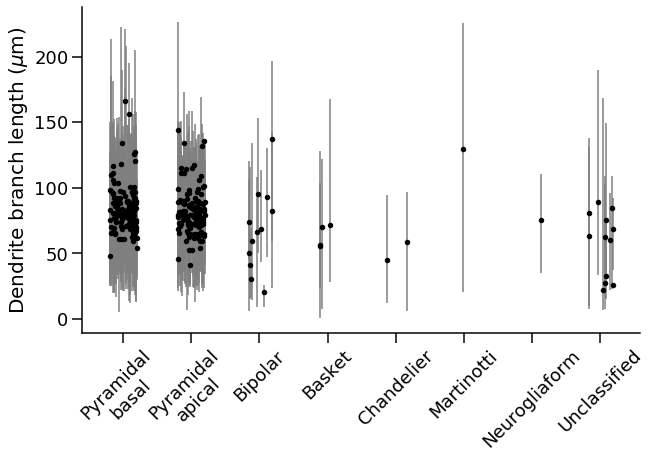

In [17]:
plt.figure(figsize=(10, 6))
levels = ["Pyramidal\nbasal", "Pyramidal\napical",
          "Bipolar", "Basket", "Chandelier", "Martinotti",
          "Neurogliaform", "Unclassified"]

errorbar_w_jitter(denddf, levels, levelcolname="full_celltype", seed=67234697)
plt.ylabel("Dendrite branch length ($\mu$m)")

plot.format_axes()
plt.show()